# Librerias

In [ ]:
library(bnlearn)
library(Rgraphviz)
library(repr)
library(gRain)
library(microbenchmark)

# Funciones

In [2]:
resample_train = function(tabla, r, n, algor){
    ptm <- proc.time()
    
    rankings = vector(mode="list")
    ais = vector(mode="list")
    
    m = nrow(tabla)
    cat("Nº filas en cada resampling:", round(m*r))
    cat("\n\n")
    
    if(algor == "hc"){
        aux = function(x){hc(x)}
    }
    if(algor == "tabu"){
        aux = function(x){tabu(x)}
    }
    
    for(i in 1:n){
        i = sample(m, size = round(m*r), replace = FALSE)
        
        options(warn=-1)
        dag = aux(tabla[i,])
        strength = arc.strength(dag, data = tabla[i,], criterion = "bic") # x2, aic...
        options(warn=0)
        
        for(i in get_isolated_nodes(dag)){
            if(is.null(ais[[i]])){
                ais[[i]] = 1
            }else{
                ais[[i]] = ais[[i]] + 1
            }
        }
        
        rank = t(apply(strength[,1:2], 1, sort))
        for(i in 1:nrow(rank)){
            nombre = paste(rank[i,1], rank[i,2], sep=" <-> ")
            if(is.null(rankings[[nombre]])){
                rankings[[nombre]] = c(i)
            }else{
                rankings[[nombre]] = c(rankings[[nombre]], i)
            }
        }
    }
    print(proc.time() - ptm)
    return(list(rankings, unlist(ais)))
}

plot_resultados_remuestreo = function(rankings, ais, lim, size){
    # strength arcos
    q1 = order(lengths(rankings), mapply(rankings, FUN='median'), decreasing=c(TRUE,FALSE))
    frec = lengths(rankings[q1])

    options(repr.plot.width = 20, repr.plot.height = 12)
    par(mar=c(27,5,1,5))

    barplot1 = barplot(frec[0:min(length(frec), lim)], las=3, border=NA, col="lightblue", cex.names=size)
    par(new = TRUE)

    boxplot(rankings[q1[0:min(length(frec), lim)]], axes = FALSE, col="red")
    axis(side=4, at = c(1,seq(10,70,10)))
    mtext("Ranking", side=4, line=3, col="red", cex=2)
    mtext("Frecuencia absoluta", side=2, line=3, col="lightblue", cex=2)

    # axis(1, at = barplot1[c(1,2)], labels = names(frec)[c(1,2)], col.axis = 2, las=3, lwd.ticks = FALSE, lwd=FALSE)
    # axis(1, at = barplot1[-c(1,2)], labels = names(frec)[-c(1,2)], col.axis = 1, las=3, lwd.ticks = FALSE, lwd=FALSE)
    
    # nodos aislados
    q2 = order(ais, decreasing=TRUE)

    par(mar=c(15,5,2,1))
    barplot(ais[q2], las=3, col="lightblue" )
    options(repr.plot.width = 6, repr.plot.height = 8)
    mtext("Frecuencia absoluta", side=2, line=3, col="lightblue", cex=2)
}

get_blacklist = function(tabla, rankings, ais, frec_th, rank_th, ais_th, n){
    q1 = order(lengths(rankings), mapply(rankings, FUN='median'), decreasing=c(TRUE,FALSE))
    frec = lengths(rankings[q1])
    
    # creo la blacklist vacia
    blacklist = matrix(ncol = 2, dimnames = list(NULL, c("from", "to")))[-1,]
    
    # añado a la blacklist los arcos que salian pocas veces en el remuestreo
    medianas = mapply(rankings, FUN='median')
    quitar = names(frec[(frec < round(n*frec_th)) & (medianas > max(medianas)*rank_th)])
    for(i in quitar){
        aux = strsplit(i, " <-> ")[[1]]
        blacklist = rbind(blacklist, c(aux[1], aux[2]))
        blacklist = rbind(blacklist, c(aux[2], aux[1]))
    }
    
    # añado a la blacklist los nodos que salian aislados muchas veces en el remuestreo
    for(i in names(ais[ais > round(n*ais_th)])){
        blacklist = add_single_to_blacklist(blacklist, i, names(tabla))
    }
    cat(dim(blacklist),"\n")
    return(blacklist)
}

add_single_to_blacklist = function(blacklist, node, names){
    b1 <- data.frame(from = names, to = node)
    b2 <- data.frame(to = names, from = node)
    return(rbind(blacklist, b1, b2))
}

get_dag = function(tabla, blacklist, whitelist, algor){
    if(algor=="hc"){
        dag <- hc(tabla, blacklist = blacklist, whitelist = whitelist)
    }
    if(algor=="tabu"){
        dag <- tabu(tabla, blacklist = blacklist, whitelist = whitelist)
    }
    
    cat(bnlearn::score(dag, data = tabla, type = "bic"),"\n")
    s = arc.strength(dag, data = tabla, criterion = "bic")
    
    return(list(dag, s))
}

plot_arc_strength = function(s, pri, sec){
    options(repr.plot.width = 8, repr.plot.height = 6)
    plot(s$strength, ylab="Arc strength (BIC)", xlab="Arc index", cex.lab=1.3)
    abline(h = pri, col="red", lwd=2)
    abline(h = sec, col="red", lwd=4)

    arcs_fuertes = s[s$strength < sec, 1:2]
    arcs_medios  = s[(s$strength >= sec) & (s$strength < pri), 1:2]
    cat("Nº arcos:", dim(s)[1], "\n")
    cat("Arcos fuertes:", dim(arcs_fuertes)[1], "\n")
    cat("Arcos medios:", dim(arcs_medios)[1], "\n")
    
    return(list(arcs_fuertes, arcs_medios))
}

plot_dag = function(dag, arcs_fuertes, arcs_medios, nodos_rect, a, b, font_size){
    par(mar=c(1,4,1,4))
    options(repr.plot.width = a, repr.plot.height = b)
    g = graphviz.plot(dag, render=FALSE)
    graph::nodeRenderInfo(g) = list(fontsize = font_size)

    graph::nodeRenderInfo(g)$fill[vstructs(dag)[,2]] = "lightblue" # resalta los nodos que forman v-estructuras
    
    graph::nodeRenderInfo(g)$shape[nodos_rect] = "rect" # pone como 'rect' los nodos exclusivos de 'citas'

    arcs = paste(arcs_fuertes$from, arcs_fuertes$to, sep = "~") # arcos fuertes
    graph::edgeRenderInfo(g)$col[arcs] = "red"
    graph::edgeRenderInfo(g)$lwd[arcs] = 6
    
#     graph::nodeRenderInfo(g)$lwd[c("PrescribedDose","NoFractions","TumorSize")] = 3

    arcs = paste(arcs_medios$from, arcs_medios$to, sep = "~") # arcos medios
    graph::edgeRenderInfo(g)$col[arcs] = "red"
    graph::edgeRenderInfo(g)$lwd[arcs] = 3

    
#     graph::nodeRenderInfo(g)$fill[c("Bolus","DiagnosisCode","DateOfBirth","CalcModelOptions","MultiFieldOptFlag")] = "green"
#     graph::nodeRenderInfo(g)$fill[c("Bolus")] = "yellow"
    Rgraphviz::renderGraph(g)
}

get_isolated_nodes = function(dag){
    nodos_aislados = c()
    for(i in bnlearn::nodes(dag)){
        padres = bnlearn::parents(dag, i)
        hijos = bnlearn::children(dag, i)
        if(length(padres)==0 & length(hijos)==0){
            nodos_aislados = c(nodos_aislados, i)
        }
    }
    return(nodos_aislados) 
}

remove_isolated_nodes = function(dag){
    for(i in get_isolated_nodes(dag)){
        dag = remove.node(dag, i)
    }
    return(dag)
}


cascada = function(dag, junction, A, B, C, state1, state2){
    cat(dsep(dag, A, C, B), "\n")

    a1 = querygrain(junction, nodes = c(A, B, C))

    cond <- setEvidence(junction, nodes = c(B), states = state1 )
    a2 = querygrain(cond, nodes = c(A, C))

    cond <- setEvidence(junction, nodes = c(B, C), states = state2 )
    a3 = querygrain(cond, nodes = c(A))

    options(repr.plot.width = 10, repr.plot.height = 5)
    barplot( rbind(a1[[A]], a2[[A]], a3[[A]]), beside=T, main=paste(A, "(A)"), col=c("blue","red","green"), las=3)
    legend("top", legend = c("Probabilidades marginales", "Probabilidades condicionadas1", "Probabilidades condicionadas2"), 
           fill = c("blue", "red","green"))

    options(repr.plot.width = 10, repr.plot.height = 5)
    barplot( rbind(a1[[B]]), beside=T, main=paste(B, "(B)"), col=c("blue"))
    legend("top", legend = c("Probabilidades marginales"), fill = c("blue"))

    options(repr.plot.width = 10, repr.plot.height = 5)
    barplot( rbind(a1[[C]], a2[[C]]), beside=T, main=paste(C, "(C)"), col=c("blue","red"), las=3)
    legend("top", legend = c("Probabilidades marginales", "Probabilidades condicionadas1"), 
       fill = c("blue", "red"))
    
}


consulta = function(dag, junction, A, B, C, nodes1, states1, nodes2, states2){
    cond <- setEvidence(junction,
                    nodes = nodes1,
                    states = states1)
    a1 = querygrain(cond, nodes = c(A, B, C))

    cond <- setEvidence(junction,
                        nodes = nodes2,
                        states = states2)
    a2 = querygrain(cond, nodes = c(A, B, C))

    options(repr.plot.width = 10, repr.plot.height = 5)
    barplot( rbind(a1[[A]], a2[[A]]), beside=T, main=paste(A,"(A)"), col=c("blue","red"))
    legend("topright", legend = c("Caso 1", "Caso 2"), fill = c("blue", "red"))

    barplot( rbind(a1[[B]], a2[[B]]), beside=T, main=paste(B,"(B)"), col=c("blue","red"))
    legend("topright", legend = c("Caso 1", "Caso 2"), fill = c("blue", "red"))

    barplot( rbind(a1[[C]], a2[[C]]), beside=T, main=paste(C,"(C)"), col=c("blue","red"))
    legend("topright", legend = c("Caso 1", "Caso 2"), fill = c("blue", "red"))
}


query = function(junction, nodos, evidencias){
    cond = setEvidence(junction, nodes = nodos, states = evidencias )
    q = querygrain(cond, nodes = nodos)
    return(q)
}

# Datos

In [15]:
planes = read.csv("data/ARIA_cleaned/planes_cat.csv", row.names=1)
cols = names(planes)
planes[cols] <- lapply(planes[cols], factor)
planes = planes[cols]
planes[c('StartDateTime')] = NULL
dim(planes)

citas = read.csv("data/ARIA_cleaned/citas_cat.csv")
citas$ScheduledActivitySer = NULL
cols = names(citas)
citas[cols] <- lapply(citas[cols], factor)
citas = citas[cols]
citas[c('StartDateTime',"ScheduledStartTime","ScheduledEndTime","ActualStartDate","ActualEndDate")] = NULL
dim(citas)

[1] 8192   44

[1] 76881    69

# Análisis de robustez (remuestreo)

In [16]:
n_p = 500
n_c = 200

# ret = resample_train(planes, 0.20, n_p, "hc"); rankings_p  = ret[[1]]; ais_p = ret[[2]]
# ret = resample_train(citas,  0.15, n_c, "hc"); rankings_c  = ret[[1]]; ais_c = ret[[2]]

In [17]:
# saveRDS(rankings_p, file = "rankings_p.rds")
# saveRDS(rankings_c, file = "rankings_c.rds")
# saveRDS(ais_p, file = "ais_p.rds")
# saveRDS(ais_c, file = "ais_c.rds")

rankings_p = readRDS(file = "rankings_p.rds")
rankings_c = readRDS(file = "rankings_c.rds")
ais_p = readRDS(file = "ais_p.rds")
ais_c = readRDS(file = "ais_c.rds")

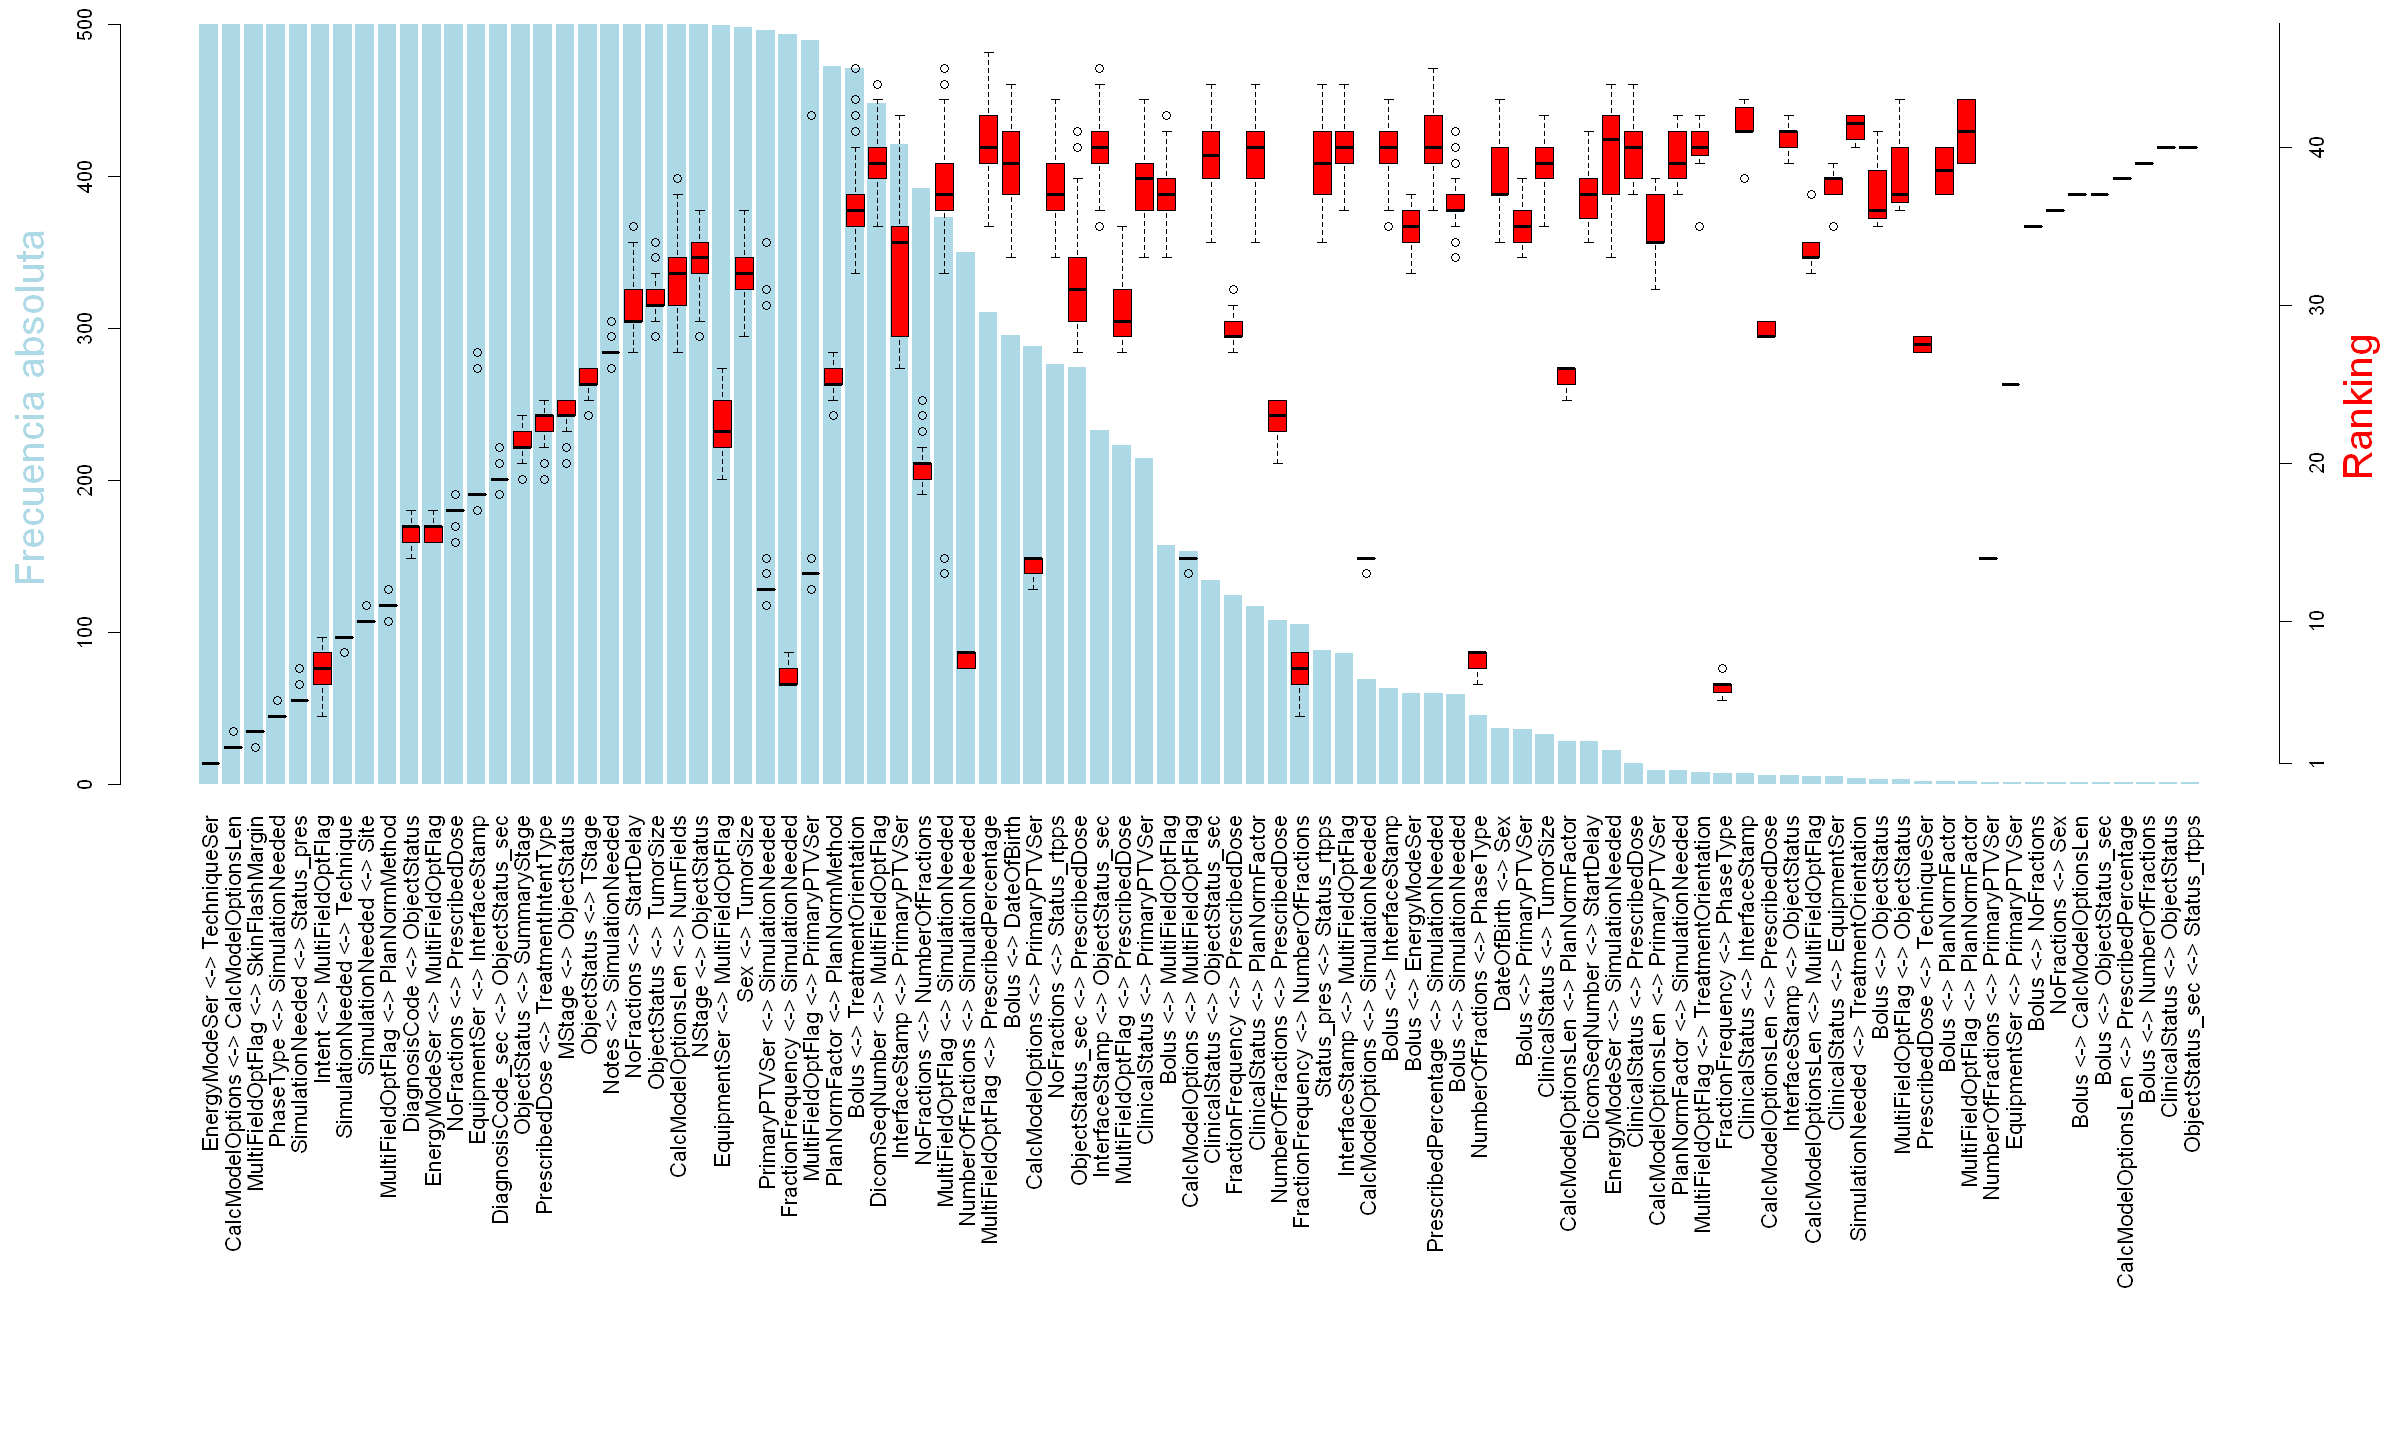

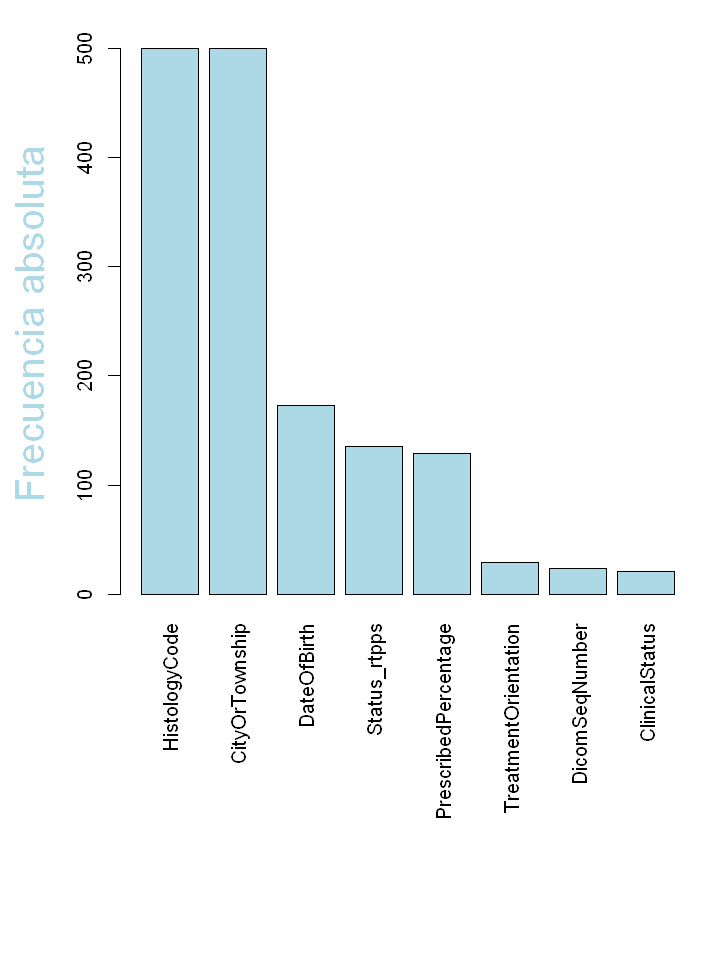

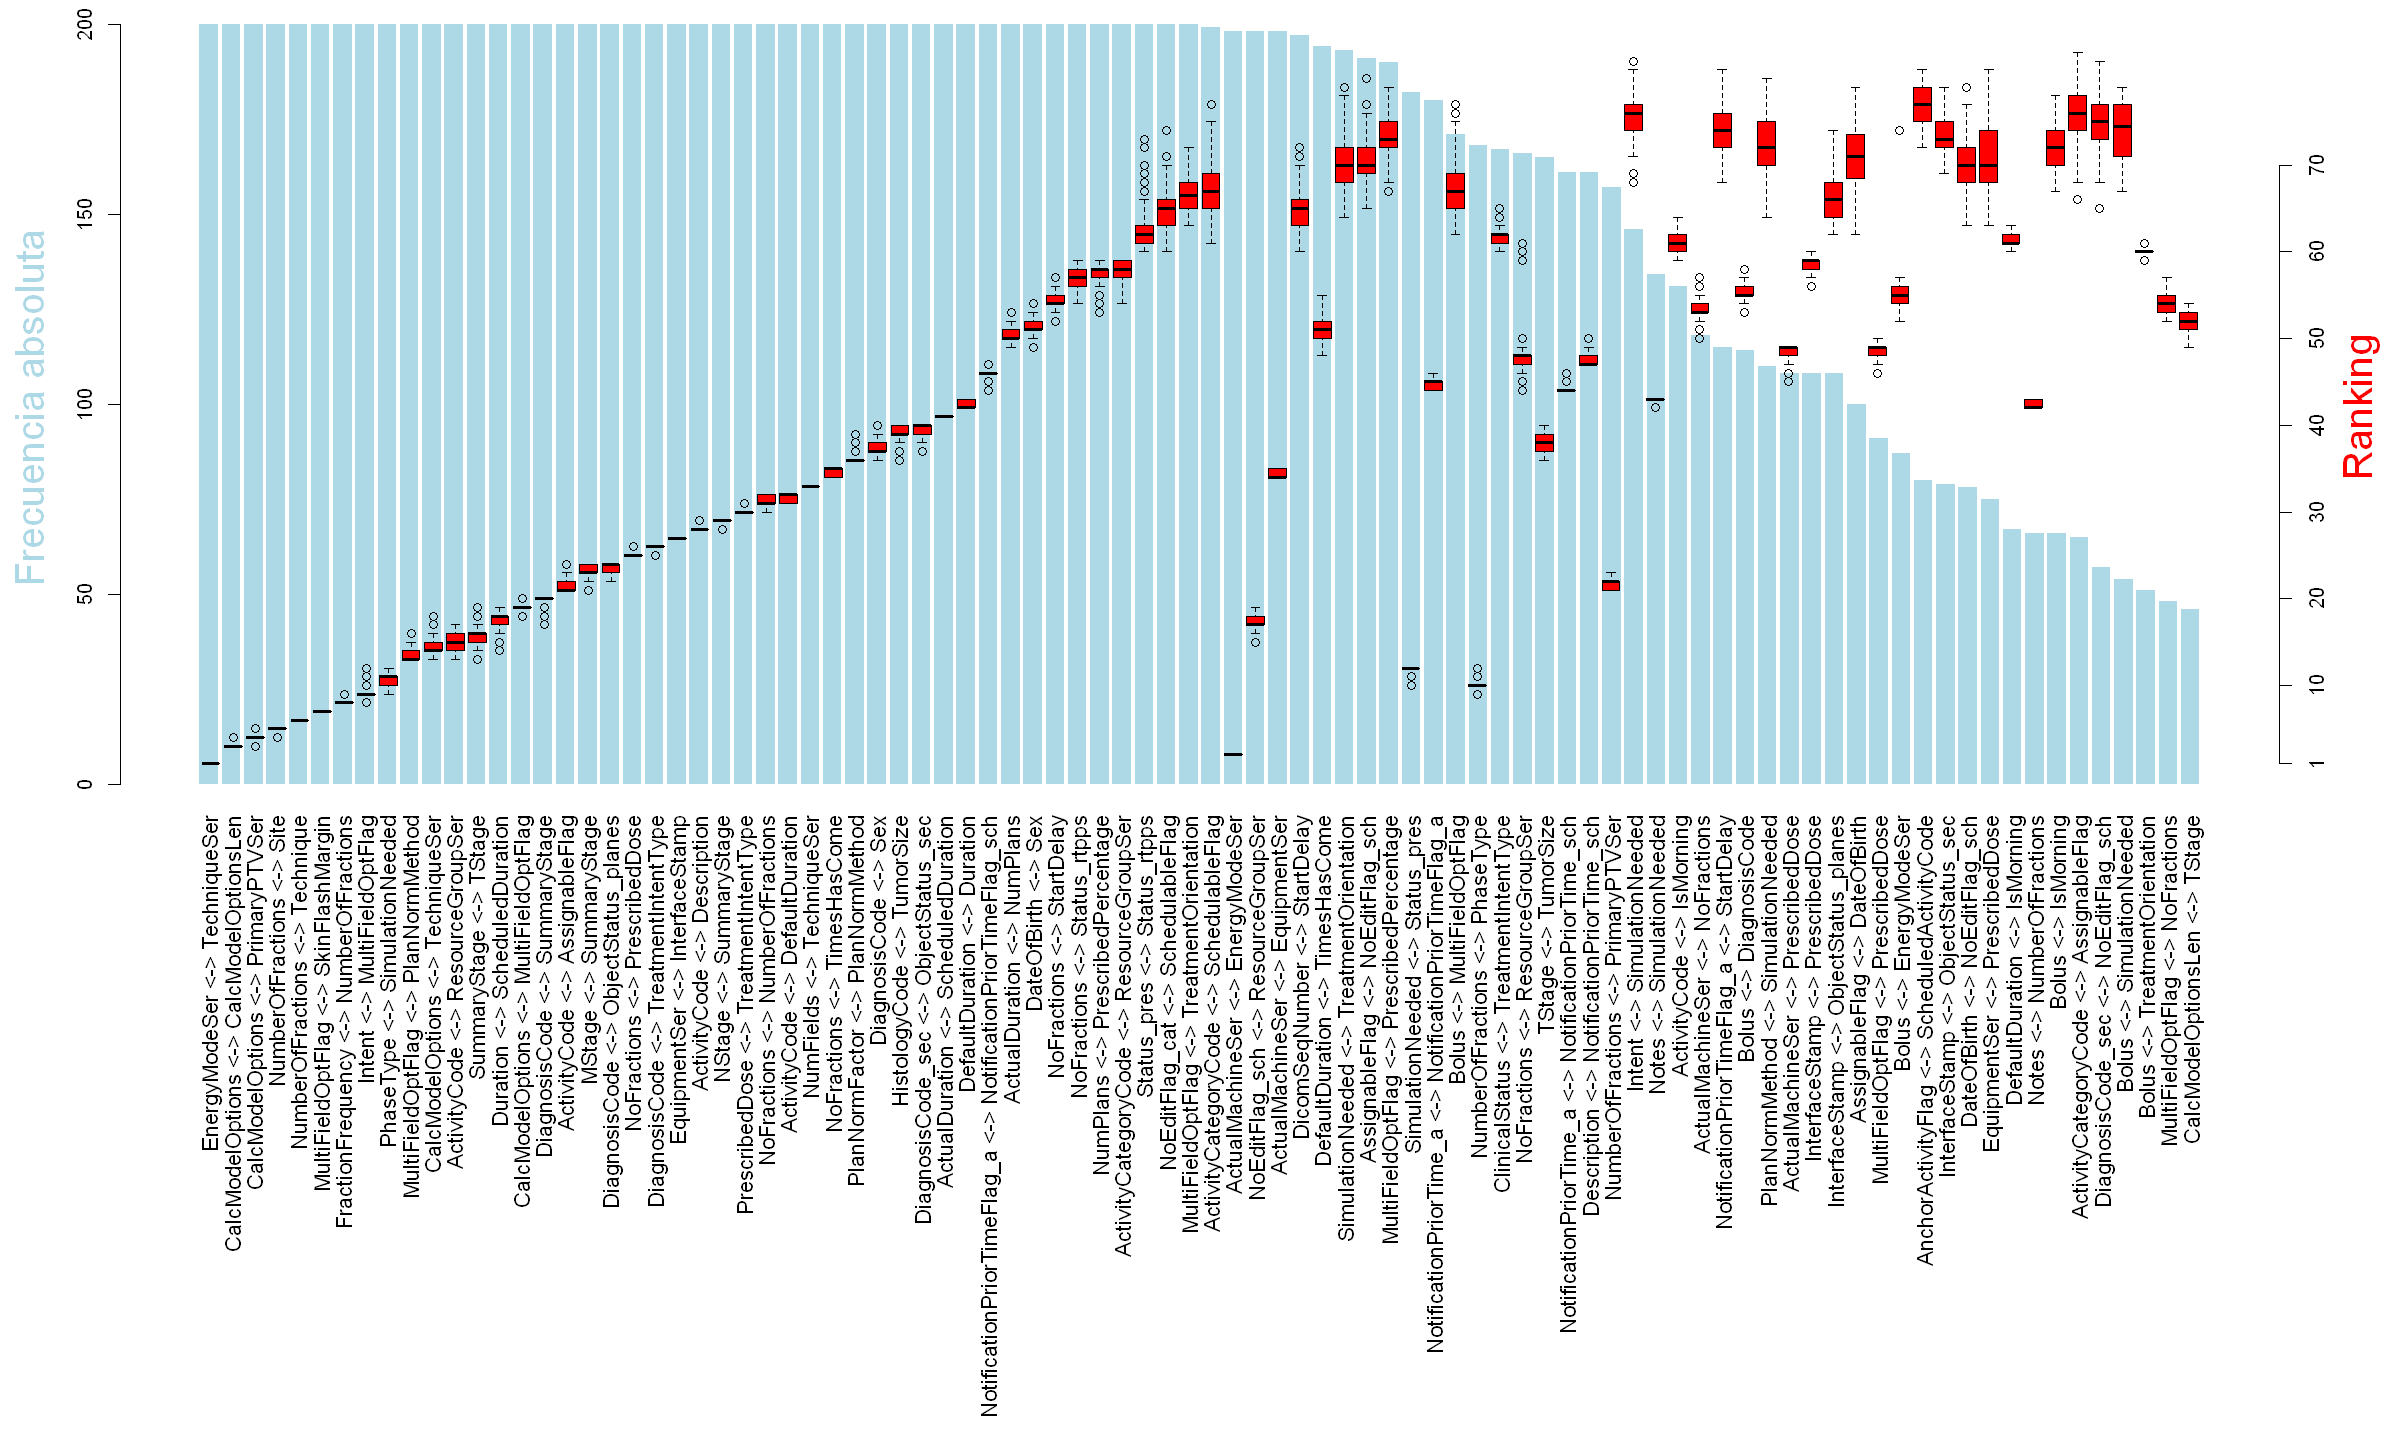

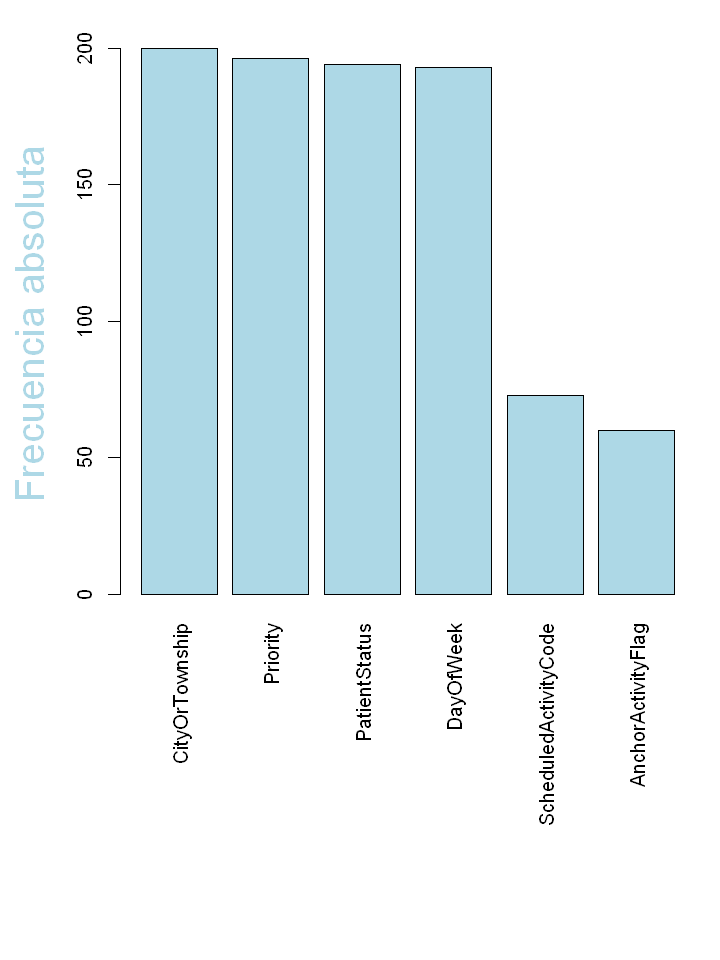

In [6]:
plot_resultados_remuestreo(rankings_p, ais_p, 90, 1.1)
plot_resultados_remuestreo(rankings_c, ais_c, 90, 1.1)

# Blacklist

In [18]:
blacklist_p = get_blacklist(planes, rankings_p, ais_p, 0.2, 0.8, 0.8, n_p)
blacklist_c = get_blacklist(citas,  rankings_c, ais_c, 0.2, 0.8, 0.8, n_c)

240 2 
622 2 


# Construir dag 
Con todos los datos y la blacklist

-2575127 
Nº arcos: 101 
Arcos fuertes: 9 
Arcos medios: 19 


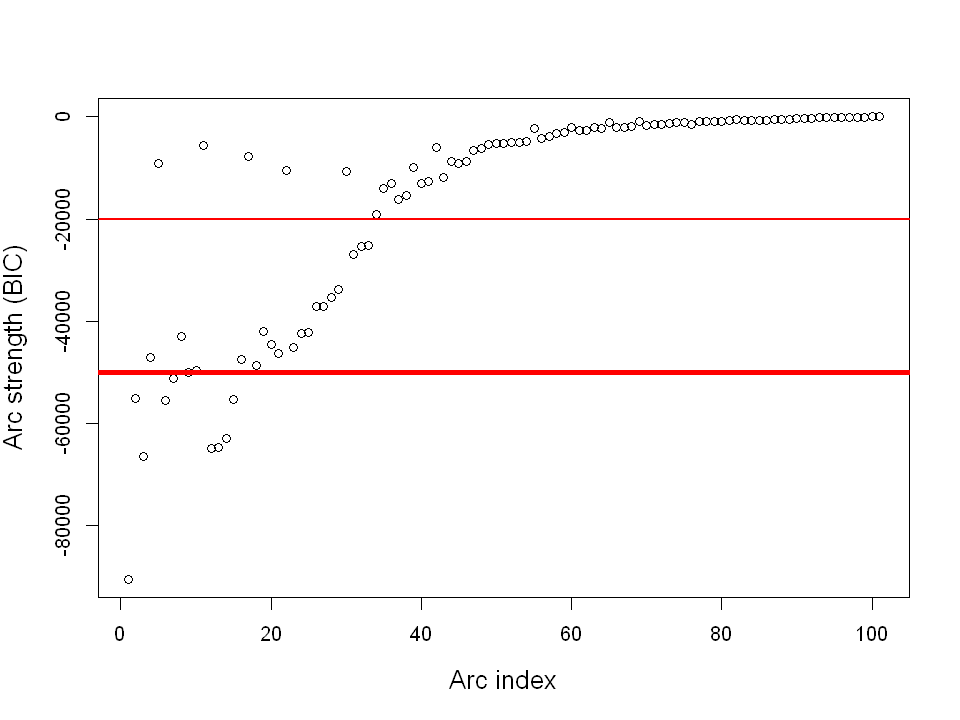

In [34]:
# ret = get_dag(planes, blacklist_p, c(), "hc"); dag_p = ret[[1]]; s_p = ret[[2]]
# ret = plot_arc_strength(s_p, -2000, -5000); arcs_fuertes_p = ret[[1]]; arcs_medios_p = ret[[2]]

ret = get_dag(citas, blacklist_c, arcs_fuertes_p, "hc"); dag_c = ret[[1]]; s_c = ret[[2]]
ret = plot_arc_strength(s_c, -20000, -50000); arcs_fuertes_c = ret[[1]]; arcs_medios_c = ret[[2]]

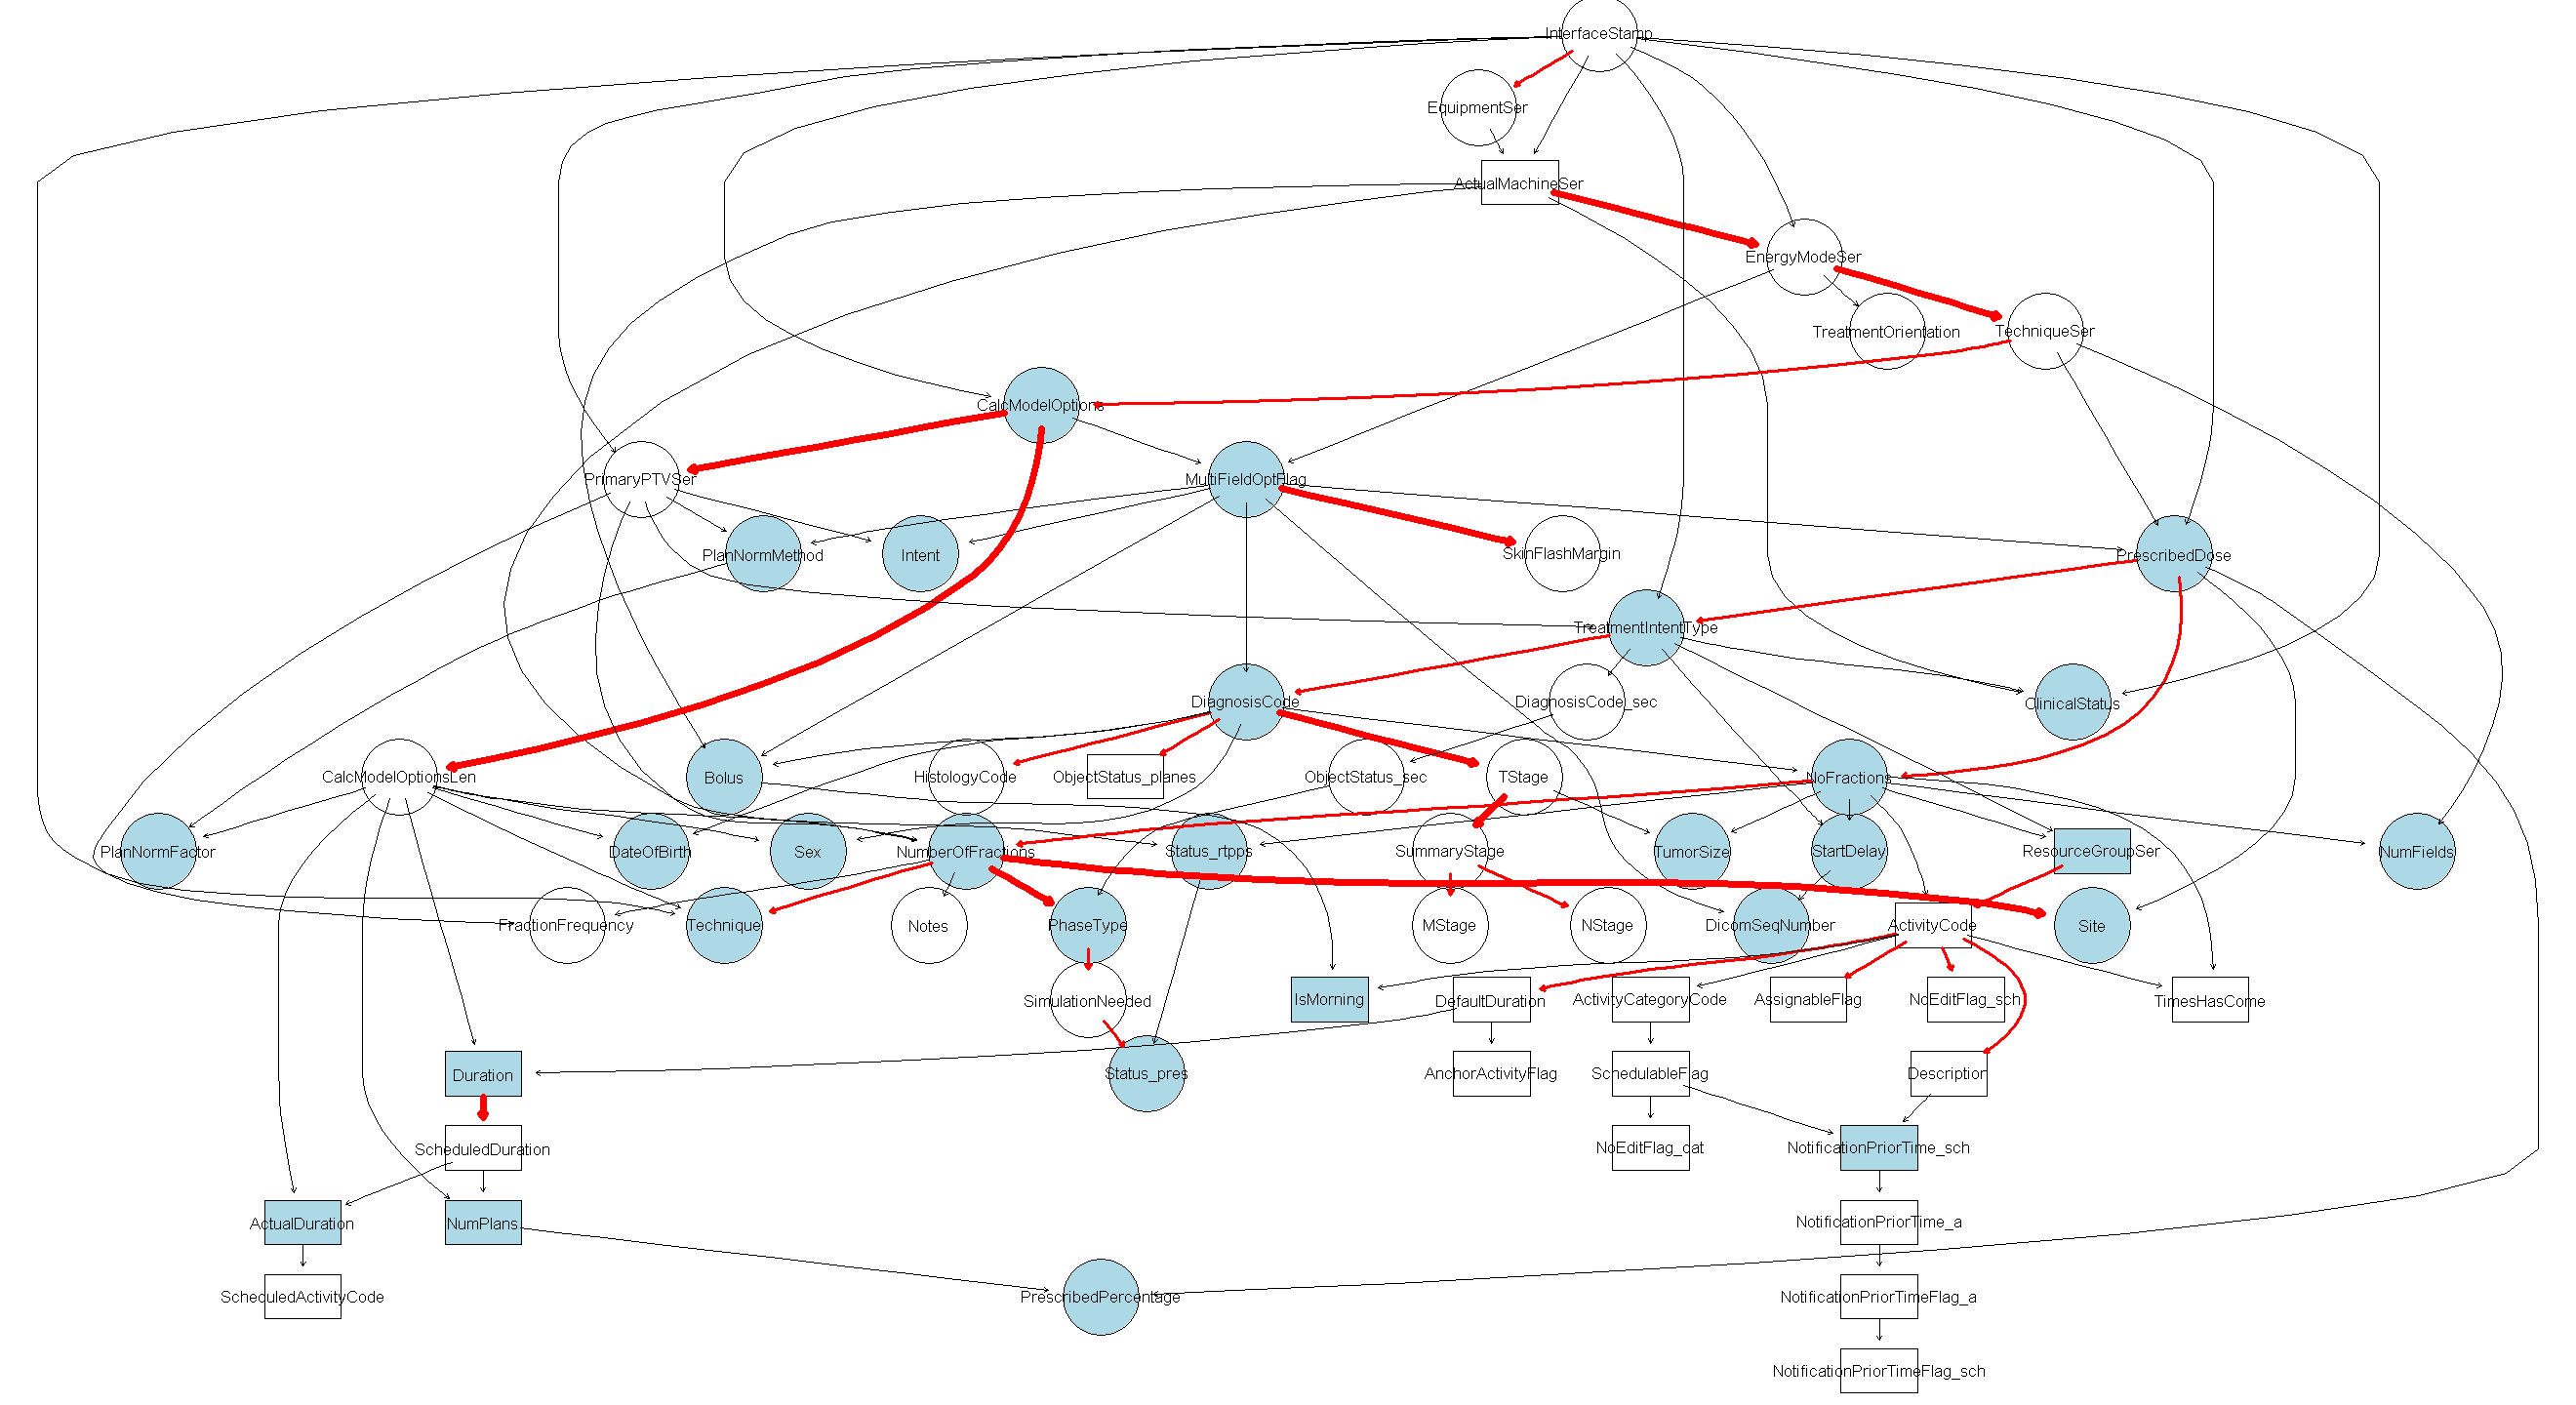

In [12]:
# remove_isolated_nodes(dag_p)
# plot_dag(remove_isolated_nodes(dag_p), arcs_fuertes_p, arcs_medios_p, c(), 18, 14, 95)
# plot_dag(remove_isolated_nodes(dag_c), arcs_fuertes_c, arcs_medios_c, setdiff(names(citas), names(planes)), 18, 8, 150)
plot_dag(remove_isolated_nodes(dag_c), arcs_fuertes_c, arcs_medios_c, setdiff(names(citas), names(planes)), 22, 12, 150)

# options(repr.plot.width = 24, repr.plot.height = 16)
# graphviz.chart(bn.bayes, grid = TRUE, bg = "beige", bar.col = "black", draw.levels=FALSE)

- **SummaryStage**: Denotes the combination of the three TNM
stages into a single staging value. Usually
denoted as a roman numeral with a single
trailing alpha character, such as IIIB.

- **InterfaceStamp**: Indicates whether this plan was
exposed to external interfaces. That is,
it whether the plan was exported or
treated. It was if its value is greater
than 0.

- **CalcModelOptions**: Algorithms and options used in dose
calculation.

- **MultiFieldOptFlag**: For proton treatment only, flag
indicating how field optimization is
performed. Values are:
 TRUE = plan has been created
using simultaneous optimization
of all fields.
 FALSE = Each field has been
optimized individually.

- **DicomSeqNumber**: Used for identifying Fractionation in
the Fractionation sequence in DICOM
environment.

- **StartDelay**: Delay, in days, until the first fraction is
applied.

- **NoFractions**: The number of fractions.

- **PrimaryPTVSer**: Reference to the PatientVolume,
defined as the PrimaryPTV for this
PlanSetup. This PTV defines the
ReferencePercent.

- **PlanNormFactor**: Plan normalization factor is the factor
by which the unnormalized plan dose
must be multiplied to normalize it.
May be given by the user from dose
volume histogram, or automatically
calculated.

- **PhaseType**: How the treatment shall be divided
up in phases.
Refer to
DEFAULT_VALUE_TREATMENT_
PHASE in Lookup data section.
Some of the Possible values are
Primary, Boost, etc.

- **NoEditFlag_sch**: Flag indicates whether the user
can edit this activity. Values are:

- **Status_pres**: Status of Prescription. Some of the
possible values are Draft, Approved,
Retired, etc.

- **NStage**: Indicates the degree to which lymph nodes
are involved with a tumor. N Stage
describes the primary tumor in terms of its
effect on lymph nodes. In the TNM staging
system, N1 through N4 indicate the degree
to which lymph nodes are affected and the
relative localization of the nodes involved.
Default is None.

- **MStage**: Indicates if distant metastases of the
primary tumor exist. In the TNM staging
system, M0 means no distant metastases
and M1 means distant metastases exist.
Default is None.

- **HistologyCode**: Standard code identifying the
type of cells comprising the
tumor.

# Aprendizaje de parámetros

In [21]:
bn.bayes_p <- bn.fit(dag_p, data = planes, method = "bayes")
bn.bayes_c <- bn.fit(dag_c, data = citas, method = "bayes")
# nparams(bn.bayes_p)
# nparams(bn.bayes_c)

In [22]:
# bn.bayes$PrescribedPercentage
# bn.bayes$Status_y
# bn.bayes$ActualMachineSer
# bn.bayes_p$TumorSize
# bn.bayes_p$Site
# bn.bayes_p$SkinFlashMargin
# bn.bayes_p$Status_pres

# Consultas condicionadas

In [23]:
junction_p <- compile(as.grain(bn.bayes_p))
junction_c <- compile(as.grain(bn.bayes_c))

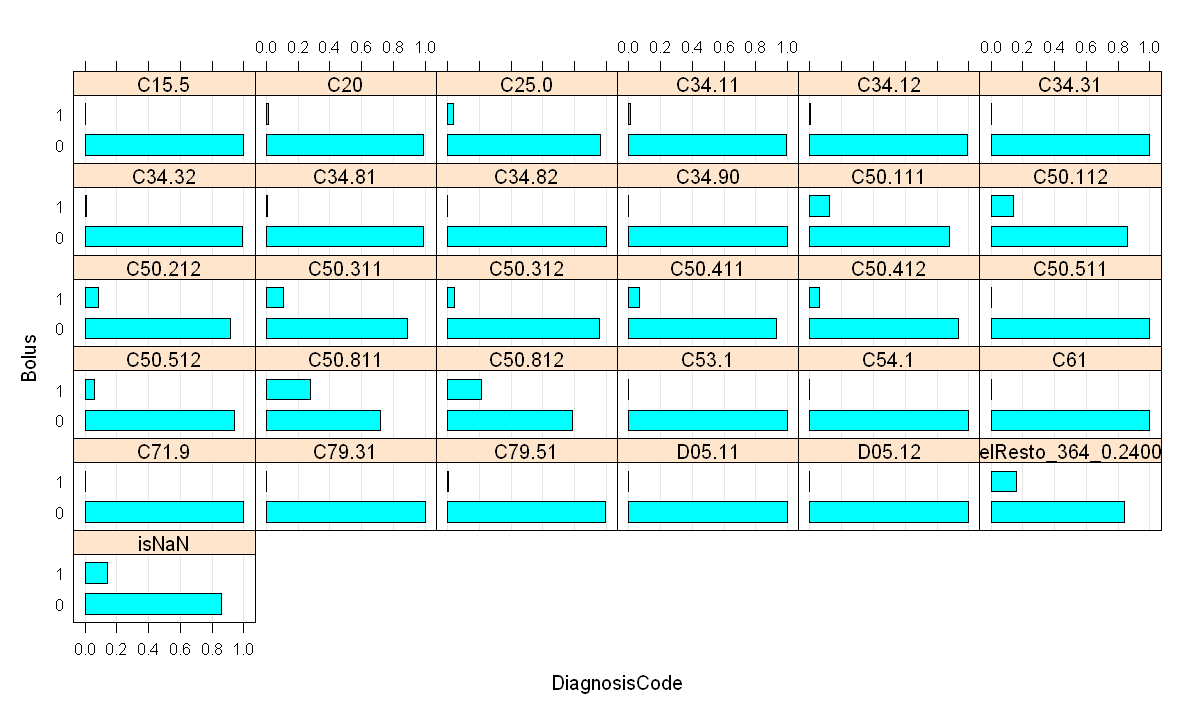

In [21]:
# Dependencia simple (A -> B), directa entre 2 nodos
# Bolus - DiagnosisCode

# bn.bayes_p$Bolus
# C15.5, C20, C50.111, C50.112

options(repr.plot.width = 10, repr.plot.height = 6)
bn.fit.barchart(bn.bayes_p$Bolus, main = "", xlab = "DiagnosisCode", ylab = "Bolus")

In [26]:
# prescribedDose - NoFractions - TumorSize

A = "PrescribedDose"
B = "NoFractions"
C = "TumorSize"
nodos = c(A,B,C)
# levels(citas[,A])
# levels(citas[,B])
# levels(citas[,C])
cat('\n\n')

evidencias0 = c('', '', '')
a0 = query(junction_c, nodos, evidencias0)

evidencias0 = c('x', 'x', '[0.0, 1.2)')
a1 = query(junction_c, nodos, evidencias0)

evidencias0 = c('x', 'x', '[1.2, 2.0)')
a2 = query(junction_c, nodos, evidencias0)

evidencias0 = c('x', 'x', '[2.0, 2.8)')
a3 = query(junction_c, nodos, evidencias0)

evidencias0 = c('x', 'x', '[2.8, 4.0)')
a4 = query(junction_c, nodos, evidencias0)

evidencias0 = c('x', 'x', '[4.0, 6.0)')
a5 = query(junction_c, nodos, evidencias0)

evidencias0 = c('x', 'x', '[6.0, 85.0)')
a6 = query(junction_c, nodos, evidencias0)

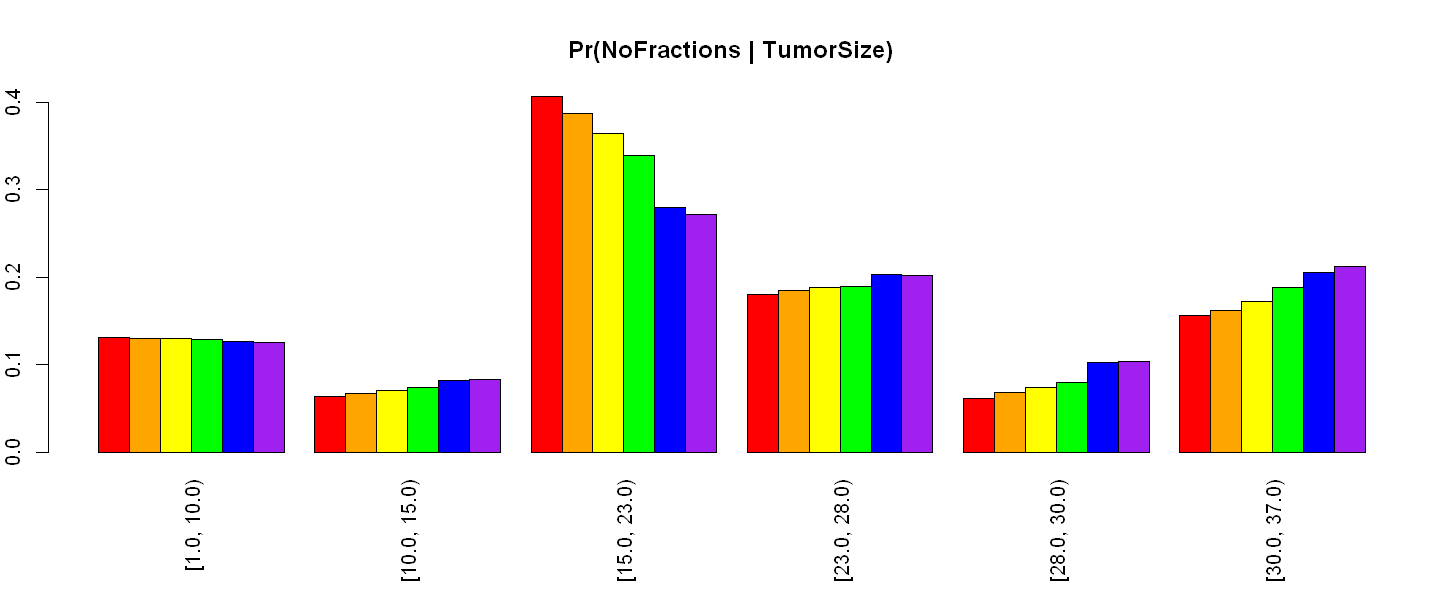

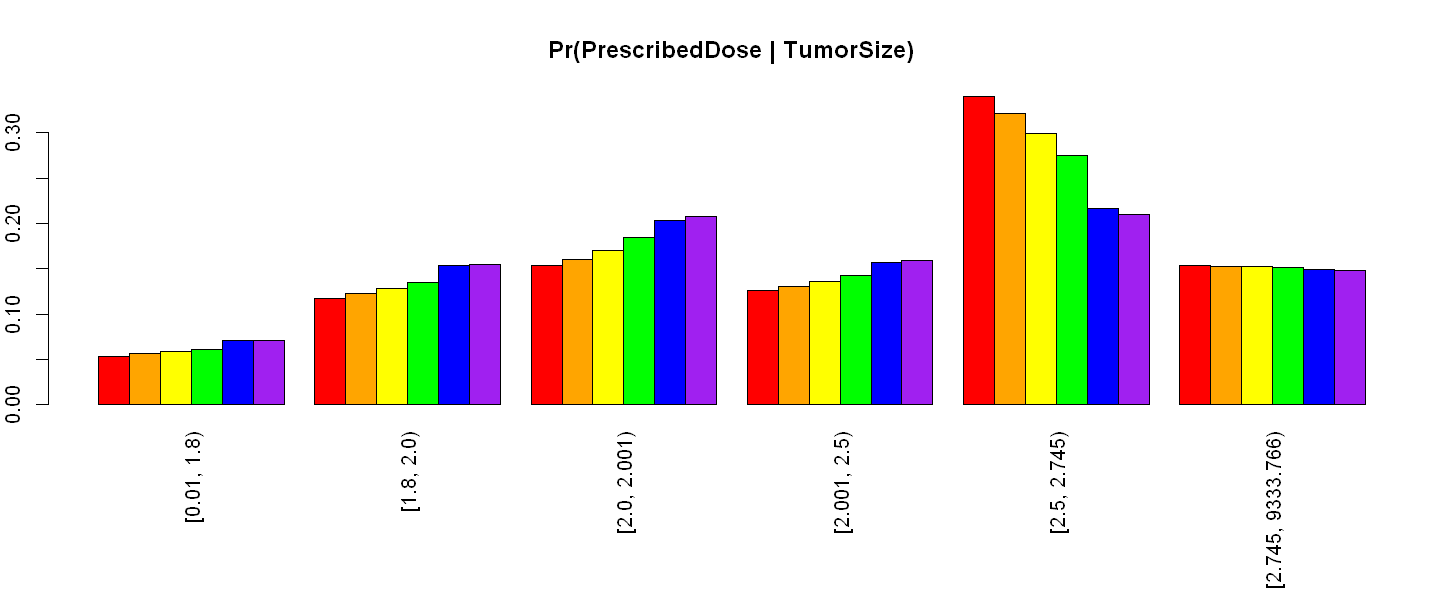

In [28]:
par(mar=c(6,2,4,1))
options(repr.plot.width = 12, repr.plot.height = 5)
barplot( rbind(a1[[B]][2:7], a2[[B]][2:7], a3[[B]][2:7], a4[[B]][2:7], a5[[B]][2:7], a6[[B]][2:7]), beside=T, main="Pr(NoFractions | TumorSize)", las=3,
        col=c("red","orange","yellow","green","blue","purple"))

par(mar=c(8,2,4,1))
options(repr.plot.width = 12, repr.plot.height = 5)
barplot( rbind(a1[[A]][2:7], a2[[A]][2:7], a3[[A]][2:7], a4[[A]][2:7], a5[[A]][2:7], a6[[A]][2:7]), beside=T, main="Pr(PrescribedDose | TumorSize)", las=3,
        col=c("red","orange","yellow","green","blue","purple"))

### Comparacion tiempos

In [ ]:
levels(citas$NumFields)
levels(citas$Technique)

In [30]:
A = "NumFields"
B = "Technique"
nodos = c(A,B)

evidencias0 = c('8')

cond <- setEvidence(junction_c,
                    nodes = c(A,B),
                    states = c('8',''))

tiempos1 = microbenchmark( querygrain(cond, nodes = c(A, B)) )$time/1e6
tiempos2 = microbenchmark( cpquery(bn.bayes_c, event = Technique == 'IMRT', 
        evidence = (NumFields == "8") ) )$time/1e6

median(tiempos1) # ms
median(tiempos2) # ms

[1] 0.203751

[1] 12.26845

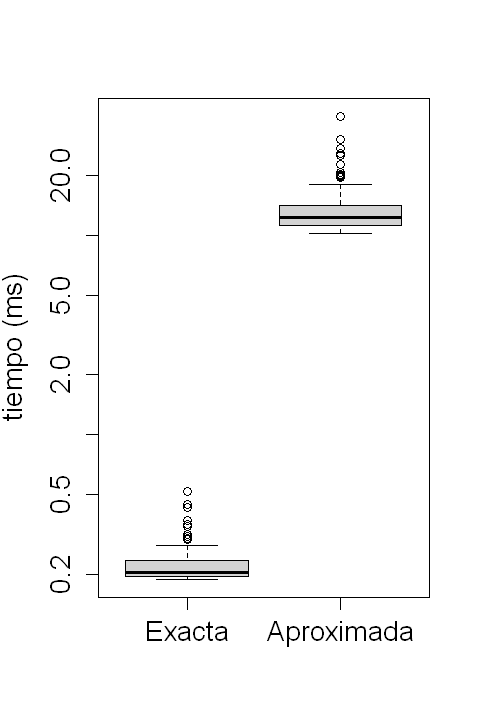

In [31]:
options(repr.plot.width = 4, repr.plot.height = 6)
par(cex.axis=1.4) # is for x-axis
boxplot( tiempos1, tiempos2, log='y', ylab='tiempo (ms)', names=c('Exacta','Aproximada'), cex.lab=1.4)

### Comparacion valores

In [32]:
a = replicate(100, cpquery(bn.bayes_c,event=Technique=='IMRT',evidence=(NumFields=="8") ),simplify=FALSE)

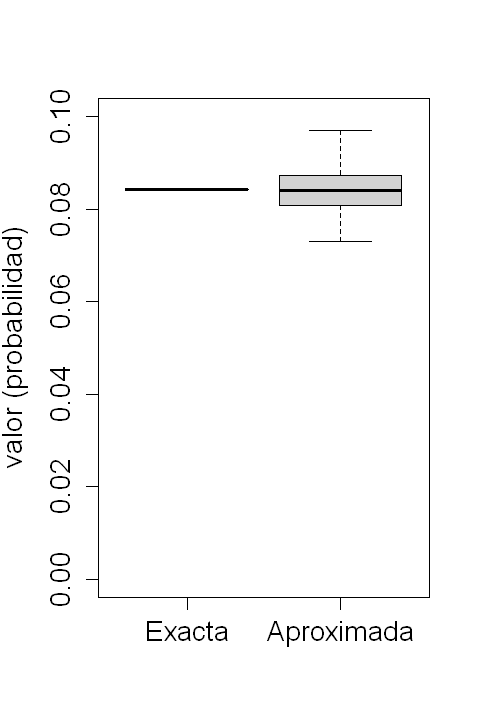

In [33]:
options(repr.plot.width = 4, repr.plot.height = 6)
par(cex.axis=1.4) # is for x-axis
boxplot(querygrain(cond, nodes = c(A, B))$Technique["IMRT"],unlist(a), ylim=c(0,0.1), ylab='valor (probabilidad)', names=c('Exacta','Aproximada'), cex.lab=1.4)